In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn 
import math
import time
import random
np.random.seed(28)

#plotting setting
size=10;f=10
figsize=(8,6)

from ML_estimator import *
from Evaluation import *
from Basic import *
from EXP3_util import *

In [2]:
filepath='C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_16/ML_prior_200_v2'

# EXP 2 ML-based Grid Search with Prior (synthetic prior)

In [3]:
def experiment3(N,lmb,d,targets,phase_obs,ml_resol,prior_means,prior_sigma,flag_prior):
    # Array
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location
    R_near=near_field_Boundary(lmb,arr_dim)
    arr_center=0.5*arr_dim
    time_ML=0
    time_ML_prior=0
    #Prepare arrays for results
    num_sam=5
    ML_targets=np.empty([len(targets),num_sam,2])
    ML_targets_prior=np.empty([len(targets),num_sam,2])

    #begin experiment
    if(flag_prior==False):
        for i in range (len(targets)):
            # if(i%50==0):
            #     print(i)
            
            for j in range(num_sam):
                #search space
                xrange=np.array([arr_center-R_near,arr_center+R_near])
                yrange=np.array([0,R_near])
                
                #ML
                T1=time.perf_counter()
                ml=ML()
                num_grid,Loc_MLgrid=ml.ML_grid(xrange,yrange,phase_obs[i,j],arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
                num=num_grid[0]*num_grid[1]
                T2=time.perf_counter()
                time_ML+=(T2-T1)
                ML_targets[i,j]=Loc_MLgrid.reshape(2)        
        print(f'ML processing time per iteration:{time_ML/(len(targets)*num_sam)}s.')
        return ML_targets, num
    else:
        for i in range (len(targets)):
            # if(i%50==0):
            #     print(i)
            
            for j in range(num_sam):
                
                #search space
                prior_mean=prior_means[i,j]

                xrange_p=np.array([prior_mean[0]-3*prior_sigma,prior_mean[0]+3*prior_sigma])
                yrange_p=np.array([prior_mean[1]-3*prior_sigma,prior_mean[1]+3*prior_sigma])

                #ML + prior bounding search space
                T1=time.perf_counter()
                ml=ML()
                num_grid,Loc_MLgrid_prior=ml.ML_grid(xrange_p,yrange_p,phase_obs[i,j],arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
                num_prior=num_grid[0]*num_grid[1]
                T2=time.perf_counter()
                time_ML_prior+=(T2-T1)
                ML_targets_prior[i,j]=Loc_MLgrid_prior.reshape(2)              
            
    
        print(f'ML + prior processing time per iteration:{time_ML_prior/(len(targets)*num_sam)}s.')
        return ML_targets_prior, num_prior


In [4]:
#main 
N=10 # number of elements
lmb=2e-3 # wavelength of the signal
d=0.25*lmb # distance between 2 adjacent elements


arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location
R_near=near_field_Boundary(lmb,arr_dim)
arr_center=0.5*arr_dim

# generating targets
N_target=200
# targets = sample_in_half_circle(R_near,N_target)+np.array([arr_center,0])
# # print(f"True target:{targets}")
# np.savetxt('targets_200_v2.txt',targets)
targets=np.loadtxt('targets_200_v2.txt')
targets=targets

# targets2=np.loadtxt('targets_200.txt')
# targets2=targets2



In [5]:
# plt.figure()
# plt.scatter(targets[:,0],targets[:,1])
# plt.scatter(targets2[:,0],targets2[:,1],c='r')

## phase noise and position noise converison

In [6]:
# noise_dB=np.array([0,10,20,30])
# phase_noise_dB= Position_dB_to_phase_dB(noise_dB,lmb)
# plt.figure()
# plt.plot(noise_dB,phase_noise_dB,'d--')
# plt.xlabel(r'Position noise $σ^{-2}$ [dB]')
# plt.ylabel(r'Phase noise $σ^{-2}$ [dB]')
# plt.grid()
# plt.savefig(filepath+'/Exp3_noise_conversion.eps',format='eps') 

 

## Exp 2-1,2-2 fixed prior sigma or fixed grid size

In [7]:
#EXP3
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ML_MSE_mean=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])


for i in range(len(position_noise_std)):
    #generate phase measurements
    true_targets,phase_observations=EXP3_position_noise_to_phase_generate(N,lmb,d,targets,position_noise_std[i],phi_0=1) #add noise to position, then generate noise-free phase 
    for k in range(len(prior_sigma)):
        # synthetic priors
        prior_means=Synthetic_prior(targets,5,prior_sigma[k,i])
        for j in range(len(ml_resol)):
            if(prior_sigma[k,0]<=4*ml_resol[j]):# Avoid too many grids (taking a long time)
                print(f'prior_sigma = {prior_sigma[k,i]/lmb} wavelength,',f'position_noise_std:{position_noise_std[i]}, ML1 resolution:{ml_resol[j]/lmb}wavelength')
                if(k==0): #just need to execute ML once for each prior_sigma
                    ML_targets,num=experiment3(N,lmb,d,targets,phase_observations,ml_resol[j],prior_means,prior_sigma[k,i],False)
                    ML_MSE_mean[i,0,j],ML_MSE_std[i,0,j]=evaluate(true_targets,ML_targets)
                    for m in range(1,len(prior_sigma)):
                        ML_MSE_mean[i,m,j]=ML_MSE_mean[i,0,j]
                        ML_MSE_std[i,m,j]=ML_MSE_std[i,0,j]
                    print(f'ML_mean_Squared_loss: {ML_MSE_mean[i,k,j]:.4},num:{num}')
                ML_targets_prior, num_prior=experiment3(N,lmb,d,targets,phase_observations,ml_resol[j],prior_means,prior_sigma[k,i],True)
                ML_MSE_mean_prior[i,k,j],ML_MSE_std_prior[i,k,j]=evaluate(true_targets,ML_targets_prior)
                print(f'ML_mean_Squared_loss_prior: {ML_MSE_mean_prior[i,k,j]:.4},num:{num_prior}')

prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.0625wavelength
ML processing time per iteration:2.271218476397917s.
ML_mean_Squared_loss: 4.468e-06,num:52975
ML + prior processing time per iteration:0.0017792773995315655s.
ML_mean_Squared_loss_prior: 1.315e-07,num:49
prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.125wavelength
ML processing time per iteration:0.4944659399013035s.
ML_mean_Squared_loss: 6.059e-06,num:13366
ML + prior processing time per iteration:0.0005983733993489295s.
ML_mean_Squared_loss_prior: 1.28e-07,num:16
prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.25wavelength
ML processing time per iteration:0.12455847639846615s.
ML_mean_Squared_loss: 8.984e-06,num:3362
ML + prior processing time per iteration:0.0001931450996780768s.
ML_mean_Squared_loss_prior: 9.275e-08,num:4
prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.5wavelength
ML processing time per iteration:0.

In [8]:
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)


ML_MSE_mean_scale=ML_MSE_mean/(lmb**2)  #scale according to wavelenth (not sure)
ML_MSE_mean_dB=todB(ML_MSE_mean_scale)
ML_MSE_std_scale=ML_MSE_std/(lmb**2)
ML_MSE_std_dB=todB(ML_MSE_mean_scale+ML_MSE_std_scale)-ML_MSE_mean_dB

ML_MSE_mean_prior_scale=ML_MSE_mean_prior/(lmb**2)  #scale according to wavelenth (not sure)
ML_MSE_mean_prior_dB=todB(ML_MSE_mean_prior_scale)
ML_MSE_std_prior_scale=ML_MSE_std_prior/(lmb**2)
ML_MSE_std_prior_dB=todB(ML_MSE_mean_prior_scale+ML_MSE_std_prior_scale)-ML_MSE_mean_prior_dB

[  0 -10 -20 -30]


d:\Jupyter\0_Spring_SP\Semester-project-2023\Evaluation.py:10: RuntimeWarning: divide by zero encountered in log
  return 10*np.log(x)/np.log(10)
d:\Jupyter\0_Spring_SP\Semester-project-2023\Evaluation.py:10: RuntimeWarning: invalid value encountered in log
  return 10*np.log(x)/np.log(10)


In [9]:

with open(filepath+'/ML_MSE_mean_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_mean_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


with open(filepath+'/ML_MSE_std_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_std_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol

with open(filepath+'/ML_MSE_mean_prior_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_mean_prior_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


with open(filepath+'/ML_MSE_std_prior_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_std_prior_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol





In [10]:
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625,0.125,0.25,0.5,1])


ML_MSE_mean_dB=np.loadtxt(filepath+'/ML_MSE_mean_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_dB=np.loadtxt(filepath+'/ML_MSE_std_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior_dB=np.loadtxt(filepath+'/ML_MSE_mean_prior_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior_dB=np.loadtxt(filepath+'/ML_MSE_std_prior_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])

[  0 -10 -20 -30]


In [11]:
def plot_result_EXP3_1(noise_scale_dB,ML_MSE_mean_dB,ML_MSE_mean_prior_dB,MSE_floor_dB,ml_resol,lmb,fixed_prior_sigma):#fix prior_sigma
    plt.figure(figsize=figsize)
    color=['b','g','purple','LightBLue','orange']
    for j in range(len(ml_resol)):
       if(fixed_prior_sigma<=2*ml_resol[j] and fixed_prior_sigma>=0.5*ml_resol[j]):
            plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,j],'o-',label=r'ML $s_{grid}=$'rf'{ml_resol[j]/lmb}$\lambda$',c=color[j])
            plt.plot(noise_scale_dB,ML_MSE_mean_prior_dB[:,j],'^-.',label=r'ML+prior $s_{grid}=$'rf'{ml_resol[j]/lmb}$\lambda$',c=color[j])
    plt.plot(noise_scale_dB,MSE_floor_dB,'d--',label=r'noise level',c='red')
    # plt.legend(bbox_to_anchor=(0.95, 1.2),ncol=3)
    plt.legend()

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-30,10])
    plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


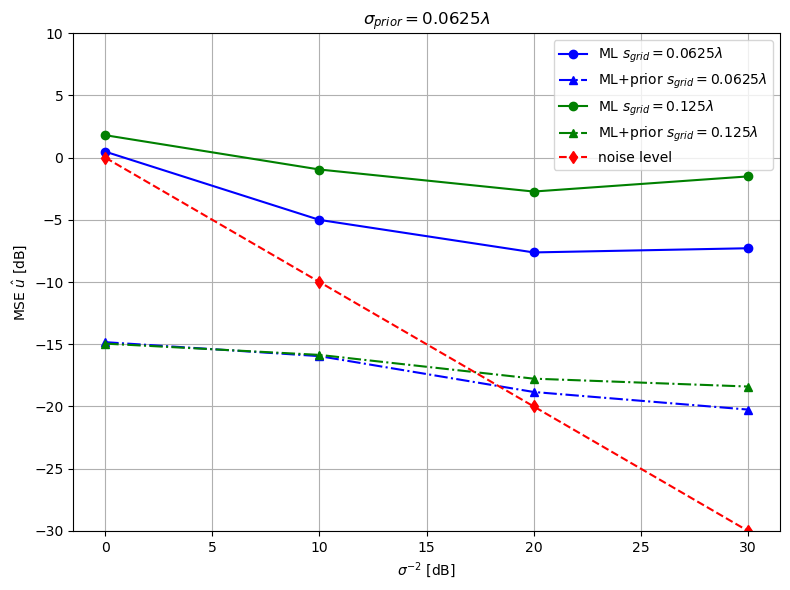

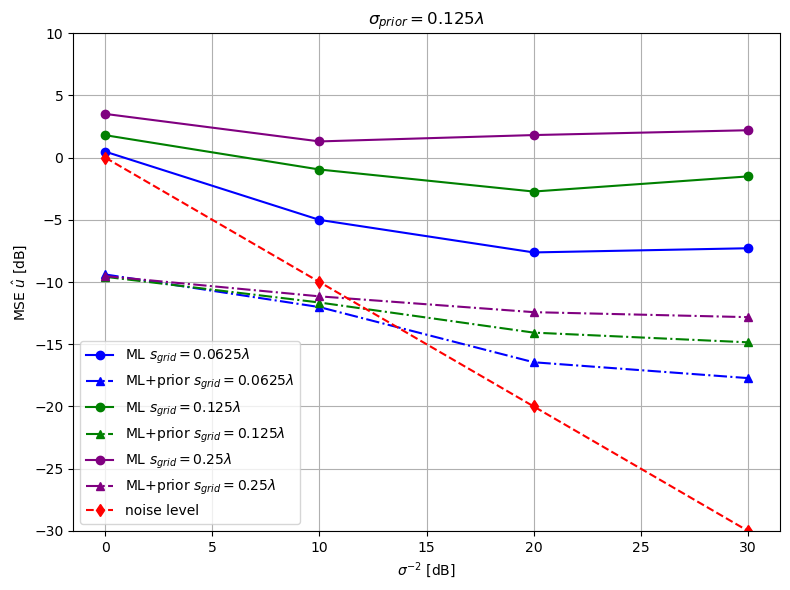

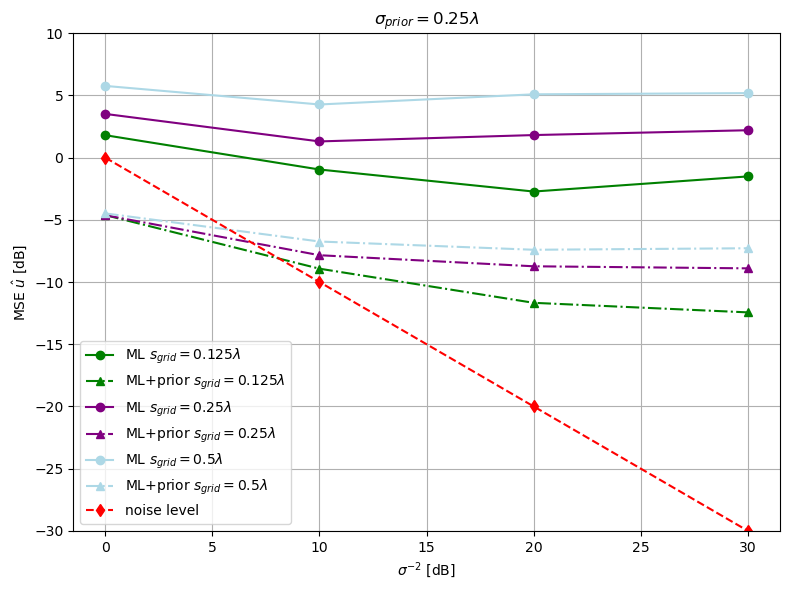

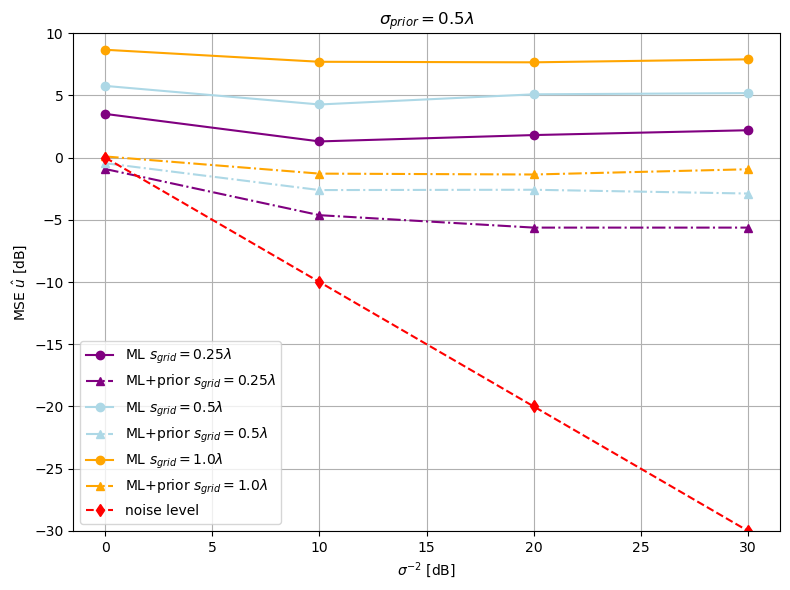

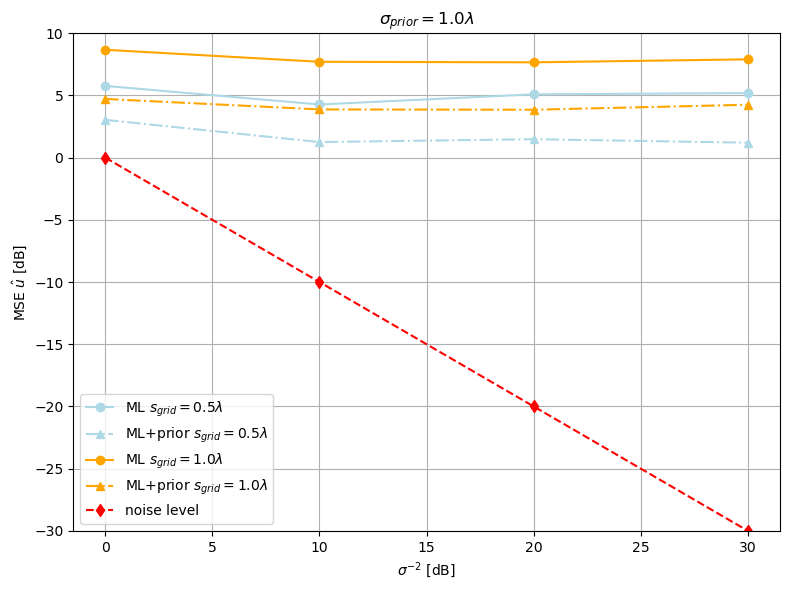

In [12]:
for i in range (len(prior_sigma)):
    plot_result_EXP3_1(noise_dB, ML_MSE_mean_dB[:,i,:],ML_MSE_mean_prior_dB[:,i,:],MSE_level_dB,ml_resol,lmb,prior_sigma[i,0])
    plt.title(r'$\sigma_{prior}=$'+f'{prior_sigma[i,0]/lmb}'+r'$\lambda$')
    plt.tight_layout()
    plt.savefig(filepath+f'/Exp3_MSE_prior_sigma_{prior_sigma[i,0]/lmb}_lmb.png')
    plt.savefig(filepath+f'/Exp3_MSE_prior_sigma_{prior_sigma[i,0]/lmb}_lmb.eps',format='eps') 

In [13]:
def plot_result_EXP3_2(noise_scale_dB,ML_MSE_mean_dB,ML_MSE_mean_prior_dB,MSE_floor_dB,prior_sigma,lmb,fixed_ml_resol):#fix ml_resol
    plt.figure(figsize=figsize)
    color=['b','g','purple','LightBLue','orange']
    plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,0],'o-',label=r'ML ',c='black')
    for j in range(len(prior_sigma)):
        if(prior_sigma[j,0]<=2*fixed_ml_resol and prior_sigma[j,0]>=0.5*fixed_ml_resol):
            plt.plot(noise_scale_dB,ML_MSE_mean_prior_dB[:,j],'^-.',label=r'ML+prior $\sigma_{prior}=$'rf'{prior_sigma[j,0]/lmb}$\lambda$',c=color[j])
    plt.plot(noise_scale_dB,MSE_floor_dB,'d--',label=r'noise level',c='red')
    # plt.legend(bbox_to_anchor=(0.95, 1.2),ncol=3)
    plt.legend()

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-30,10])
    plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


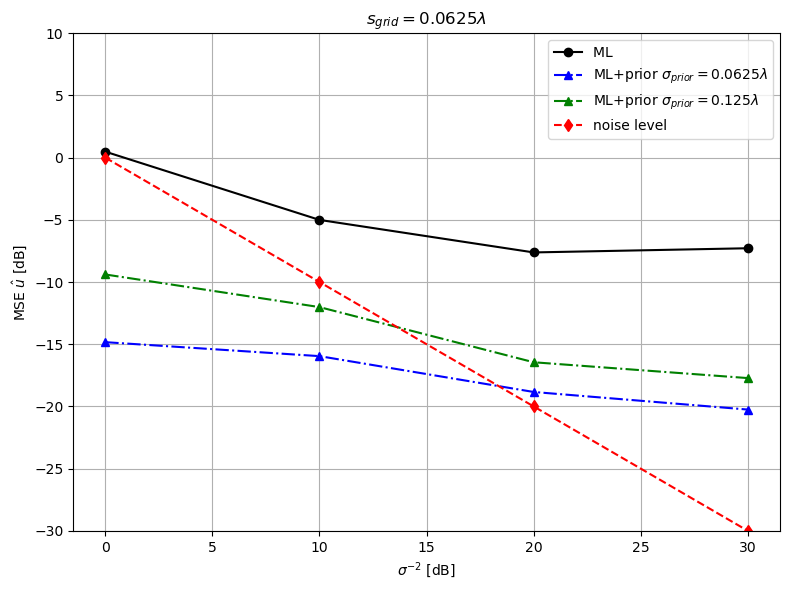

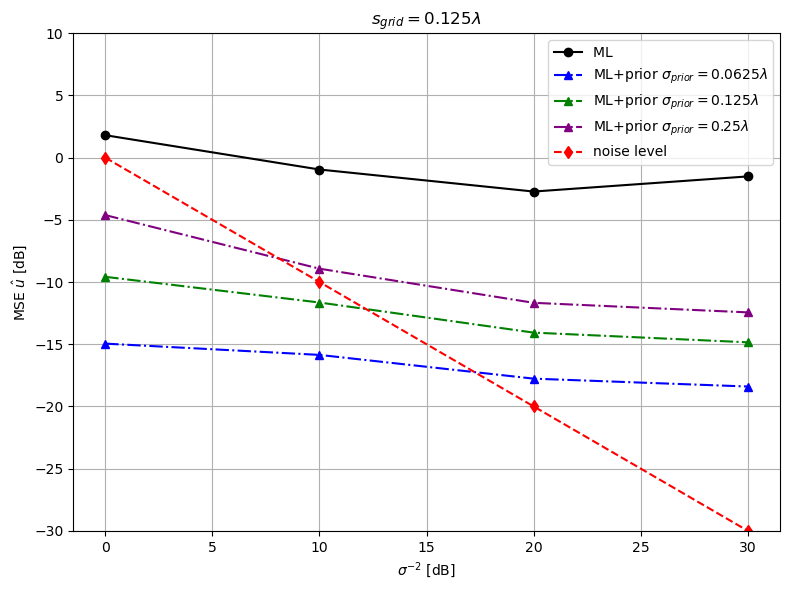

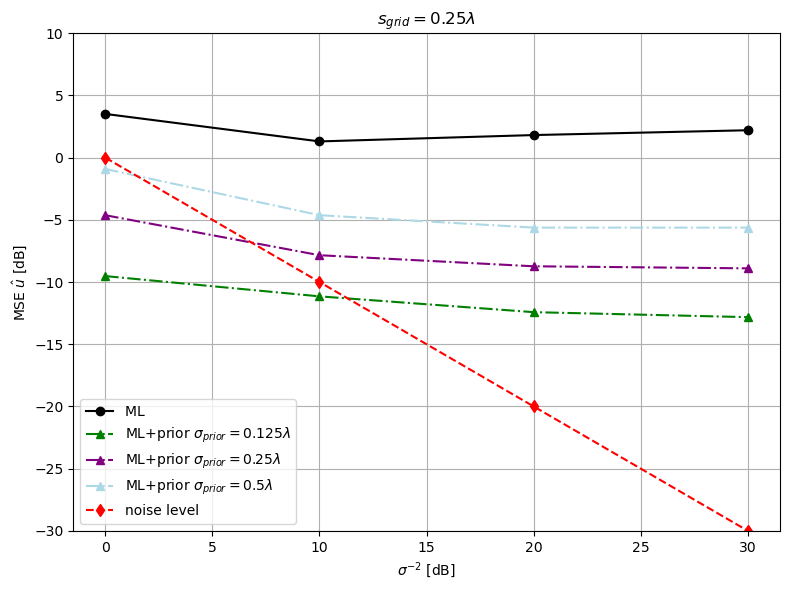

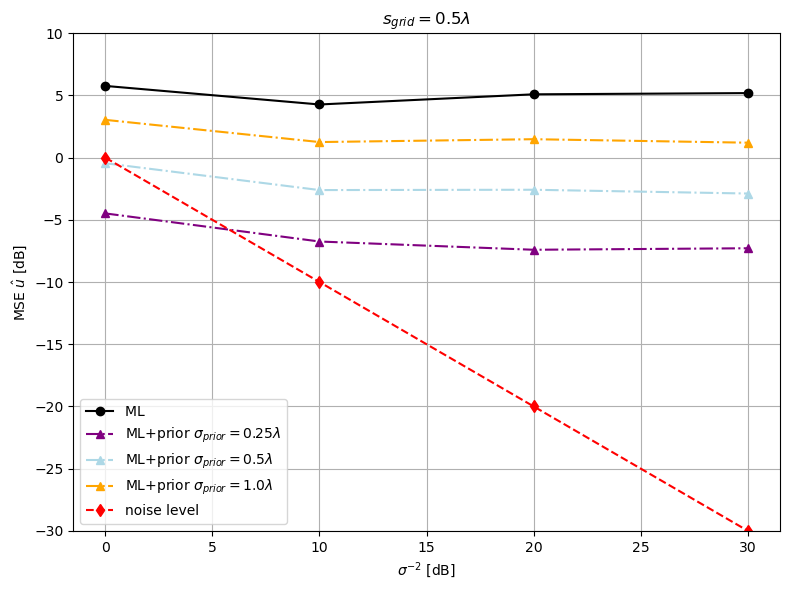

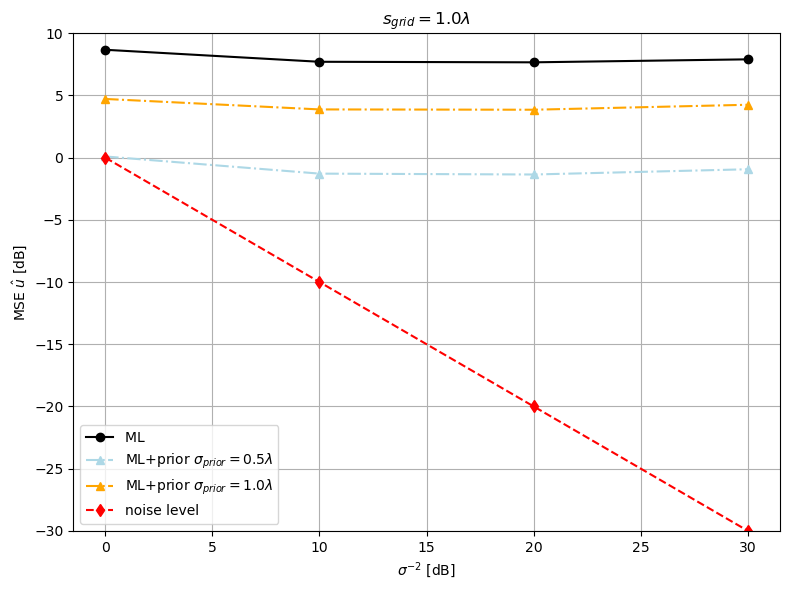

In [14]:
for i in range (len(ml_resol)):
    plot_result_EXP3_2(noise_dB, ML_MSE_mean_dB[:,:,i],ML_MSE_mean_prior_dB[:,:,i],MSE_level_dB,prior_sigma,lmb,ml_resol[i])
    plt.title(r'$s_{grid}=$'rf'{ml_resol[i]/lmb}$\lambda$')
    plt.tight_layout()
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]/lmb}_lmb.png')
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]/lmb}_lmb.eps',format='eps') 



## EXP2 special check . 
with a good resolution , the source of error due to SNR will be dominant （The slope becomes steeper).
But maybe the prior still has an effect (a poor prior with large variance). Check if this effect could be neglected.
Fix grid_size = 0.625lambda, priors (standard deviation) let us consider 0.0125, 0.25, 0.5 (you can maybe also consider 1).

In [15]:
#EXP3-speical 

noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625])

ML_MSE_mean=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])


for i in range(len(position_noise_std)):
    #generate phase measurements
    true_targets,phase_observations=EXP3_position_noise_to_phase_generate(N,lmb,d,targets,position_noise_std[i],phi_0=1) #add noise to position, then generate noise-free phase 
    for k in range(len(prior_sigma)):
        # synthetic priors
        prior_means=Synthetic_prior(targets,5,prior_sigma[k,i])
        for j in range(len(ml_resol)):
            print(f'prior_sigma = {prior_sigma[k,i]/lmb} wavelength,',f'position_noise_std:{position_noise_std[i]}, ML resolution:{ml_resol[j]/lmb}wavelength')

            ML_targets_prior, num_prior=experiment3(N,lmb,d,targets,phase_observations,ml_resol[j],prior_means,prior_sigma[k,i],True)
            ML_MSE_mean_prior[i,k,j],ML_MSE_std_prior[i,k,j]=evaluate(true_targets,ML_targets_prior)
            print(f'ML_mean_Squared_loss_prior: {ML_MSE_mean_prior[i,k,j]:.4},num:{num_prior}')
            

prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
ML + prior processing time per iteration:0.0017880716011859476s.
ML_mean_Squared_loss_prior: 1.367e-07,num:49
prior_sigma = 0.125 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
ML + prior processing time per iteration:0.005969258801313117s.
ML_mean_Squared_loss_prior: 4.679e-07,num:144
prior_sigma = 0.25 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
ML + prior processing time per iteration:0.022013879701844416s.
ML_mean_Squared_loss_prior: 1.4e-06,num:600
prior_sigma = 0.5 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
ML + prior processing time per iteration:0.0861912109007826s.
ML_mean_Squared_loss_prior: 3.112e-06,num:2401
prior_sigma = 1.0 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
ML + prior processing time per iteration:0.3423503975046333s.
ML_mean_Squared_loss_prior: 4.433e-06,num:9409
prior_sigma = 0.0625 wa

In [16]:
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)

ML_MSE_mean_prior_scale=ML_MSE_mean_prior/(lmb**2)  #scale according to wavelenth (not sure)
ML_MSE_mean_prior_dB=todB(ML_MSE_mean_prior_scale)
ML_MSE_std_prior_scale=ML_MSE_std_prior/(lmb**2)
ML_MSE_std_prior_dB=todB(ML_MSE_mean_prior_scale+ML_MSE_std_prior_scale)-ML_MSE_mean_prior_dB

[  0 -10 -20 -30]


In [17]:

with open(filepath+'/ML_MSE_mean_prior_dB_special.txt', 'w') as outfile:
        for slice_2d in ML_MSE_mean_prior_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


with open(filepath+'/ML_MSE_std_prior_dB_special.txt', 'w') as outfile:
        for slice_2d in ML_MSE_std_prior_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


In [18]:
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625])


ML_MSE_mean_dB=np.loadtxt(filepath+'/ML_MSE_mean_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),5])
ML_MSE_std_dB=np.loadtxt(filepath+'/ML_MSE_std_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),5])
ML_MSE_mean_dB=ML_MSE_mean_dB[:,:,0].reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_dB=ML_MSE_std_dB[:,:,0].reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior_dB=np.loadtxt(filepath+'/ML_MSE_mean_prior_dB_special.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior_dB=np.loadtxt(filepath+'/ML_MSE_std_prior_dB_special.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])

[  0 -10 -20 -30]


In [19]:
def plot_result_EXP3_2_special(noise_scale_dB,ML_MSE_mean_dB,ML_MSE_mean_prior_dB,MSE_floor_dB,prior_sigma,lmb,fixed_ml_resol):#fix ml_resol
    plt.figure(figsize=figsize)
    color=['b','g','purple','LightBLue','orange']
    plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,0],'o-',label=r'ML ',c='black')
    for j in range(len(prior_sigma)):
        if(prior_sigma[j,0]<=16*fixed_ml_resol and prior_sigma[j,0]>=0.5*fixed_ml_resol):
            plt.plot(noise_scale_dB,ML_MSE_mean_prior_dB[:,j],'^-.',label=r'ML+prior $\sigma_{prior}=$'rf'{prior_sigma[j,0]/lmb}$\lambda$',c=color[j])
    plt.plot(noise_scale_dB,MSE_floor_dB,'d--',label=r'noise level',c='red')
    # plt.legend(bbox_to_anchor=(0.95, 1.2),ncol=3)
    plt.legend()

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-30,10])
    plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


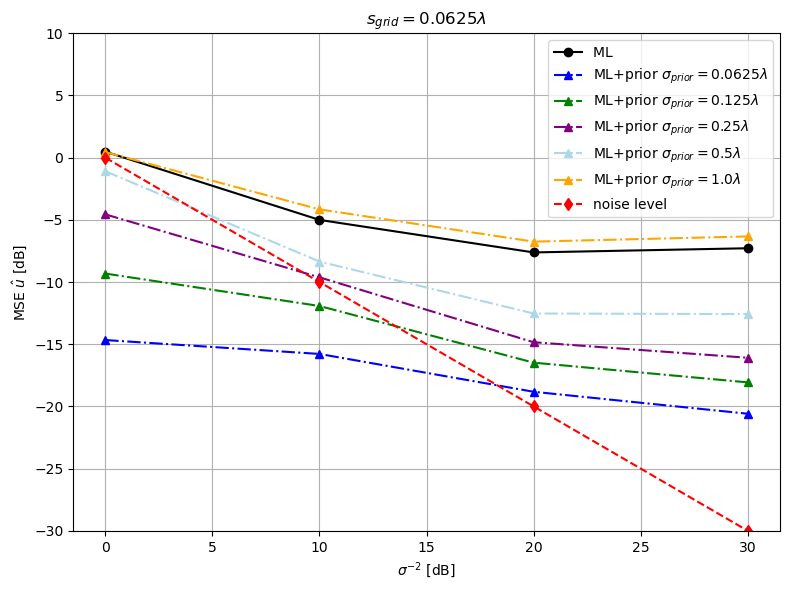

In [20]:
for i in range(len(ml_resol)):
    plot_result_EXP3_2_special(noise_dB, ML_MSE_mean_dB[:,:,i],ML_MSE_mean_prior_dB[:,:,i],MSE_level_dB,prior_sigma,lmb,ml_resol[i])
    plt.title(r'$s_{grid}=$'rf'{ml_resol[i]/lmb}$\lambda$')
    plt.tight_layout()
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]/lmb}_lmb_speicial.png')
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]/lmb}_lmb_speicial.eps',format='eps') 
